In [ ]:
import pandas as pd
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import os, pickle
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from itertools import product
import sys

import trajectory as T                      # trajectory generation
import optimizer as O                       # stochastic gradient descent optimizer
import solver as S                          # MDP solver (value-iteration)
import plot as P

## for visualization
from sklearn import datasets, preprocessing, model_selection
##

num_data = 355504

np.random.seed(66)

def to_interval(istr):
    c_left = istr[0]=='['
    c_right = istr[-1]==']'
    closed = {(True, False): 'left',
              (False, True): 'right',
              (True, True): 'both',
              (False, False): 'neither'
              }[c_left, c_right]
    left, right = map(pd.to_datetime, istr[1:-1].split(','))
    return pd.Interval(left, right, closed)

re_split = False
frac = [0.4,0.2,0.4]
assert np.sum(frac) == 1
frac = np.cumsum(frac)
print (frac)
data_save_path= 'data/'

def sliding(gs, window_size = 6):
    npr_l = []
    for g in gs:
        npr = np.concatenate([np.zeros([window_size-1, g.shape[1]]),g])
        npr_l.append(sliding_window_view(npr, (window_size, g.shape[1])).squeeze(1))
    return np.vstack(npr_l)

[0.4 0.6 1. ]


# Load data & build landscape

In [ ]:
# Kmeans clustering done on separate script
num_clusters = 100
X_df = pd.read_csv('X_df_kmeans_100.csv')
y_df = pd.read_csv('y_df_kmeans_100.csv')



In [ ]:
X_df.head()

,creatinine,fraction_inspired_oxygen,lactate,urine_output,alanine_aminotransferase,asparate_aminotransferase,mean_blood_pressure,diastolic_blood_pressure,systolic_blood_pressure,gcs,partial_pressure_of_oxygen,heart_rate,temperature,respiratory_rate,cluster
0,-0.422008,-1.760743,-0.182521,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,-0.186486,86.0,37.0,19.0,38
1,-0.422008,-1.760743,-0.182521,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,-0.186486,86.0,37.0,19.0,38
2,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0,38
3,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0,38
4,-0.422008,-1.760743,0.360532,-0.225783,-0.288689,-0.265706,0.404836,0.391566,0.36885,-2.479374,2.356989,86.0,37.0,19.0,38


In [ ]:
# BC model: NN
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(states_onehot.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(actions_onehot.shape[1], activation='softmax')  # Output layer with softmax for discrete actions
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])
    return model


In [ ]:
# Convert states and actions to one-hot encoding
state_encoder = OneHotEncoder(sparse=False, categories= [np.arange(num_clusters)])
action_encoder = OneHotEncoder(sparse=False, categories= [np.arange(4)])


states_onehot = state_encoder.fit_transform(X_df['cluster'].to_numpy().reshape(-1, 1))
actions_onehot = action_encoder.fit_transform(y_df.to_numpy().reshape(-1, 1))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
seed = 42
tf.random.set_seed(seed)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
      "./weights/sgd.{epoch:02d}.hdf5", verbose=0, save_weights_only=True, period=1)

model = build_model()

In [ ]:
# fit and train
model.fit(states_onehot, actions_onehot,  epochs=5, batch_size=128,verbose=0, callbacks=[checkpoint])


In [ ]:
model.metrics_names

['loss', 'accuracy']

In [ ]:
# visualization: setting up 3-D axes
# inspiration: Hao Li, Zheng Xu, Gavin Taylor, Christoph Studer and Tom Goldstein. Visualizing the Loss Landscape of Neural Nets. NIPS, 2018.
import h5py

def get_vectors(model, seed=None, trajectory=None):

    np.random.seed(seed)
    vector_x, vector_y = list(), list()
    weights = model.get_weights()

    cast = np.array([1]).T
    for layer in weights:
        # set standard normal parameters
        # filter-wise normalization
        k = len(layer.shape) - 1
        d = np.random.multivariate_normal([0], np.eye(1), layer.shape).reshape(
            layer.shape
        )
        dist_x = (
            d / (1e-10 + cast * np.linalg.norm(d, axis=k))[:, np.newaxis]
        ).reshape(d.shape)

        vector_x.append(
            (
                dist_x * (cast * np.linalg.norm(layer, axis=k))[:, np.newaxis]
            ).reshape(d.shape)
        )

        d = np.random.multivariate_normal([0], np.eye(1), layer.shape).reshape(
            layer.shape
        )
        dist_y = (
            d / (1e-10 + cast * np.linalg.norm(d, axis=k))[:, np.newaxis]
        ).reshape(d.shape)

        vector_y.append(
            (
                dist_y * (cast * np.linalg.norm(layer, axis=k))[:, np.newaxis]
            ).reshape(d.shape)
        )

    return weights, vector_x, vector_y

def _obj_fn(model, data, solution):
    old_weights = model.get_weights()
    model.set_weights(solution)
    value = model.evaluate(data[0], data[1], verbose=0)
    model.set_weights(old_weights)

    return value


def build_mesh(
    model,
    data,
    grid_length,
    extension=1,
    filename="meshfile",
    verbose=True,
    seed=None,
    trajectory=None,
):

    # logging.basicConfig(level=logging.INFO)
    # print("starting")
    z_keys = model.metrics_names
    z_keys[0] = model.loss
    Z = list()
    # get vectors and set spacing
    assert trajectory == None
    # print("starting vectors")
    origin, vector_x, vector_y = get_vectors(model, seed=seed, trajectory=trajectory)
    # print("got vectors")
    space = np.linspace(-extension, extension, grid_length)

    X, Y = np.meshgrid(space, space)

    for i in range(grid_length):
        for j in range(grid_length):
            print("iteration: ", i, j)
            solution = [origin[x] + X[i][j] * vector_x[x] + Y[i][j] * vector_y[x]
                for x in range(len(origin))]
            Z.append(_obj_fn(model, data, solution))
    print("finished grid length")

    Z = np.array(Z)
    os.makedirs("./files", exist_ok=True)

    with h5py.File("./files/{}.hdf5".format(filename), "w") as f:

        f["space"] = space
        original_results = _obj_fn(model, data, origin)

        for i, metric in enumerate(z_keys):
            f["original_" + metric] = original_results[i]
            f[metric] = Z[:, i].reshape(X.shape)
        f.close()
    print("status: closed h5py file")
    # memory clean-up
    del Z
    gc.collect()


In [ ]:
build_mesh(model, (states_onehot, actions_onehot),grid_length=10, verbose=0, seed=seed)

iteration:  0 0
iteration:  0 1
iteration:  0 2
iteration:  0 3
iteration:  0 4
iteration:  0 5
iteration:  0 6
iteration:  0 7
iteration:  0 8
iteration:  0 9
iteration:  1 0
iteration:  1 1
iteration:  1 2
iteration:  1 3
iteration:  1 4
iteration:  1 5
iteration:  1 6
iteration:  1 7
iteration:  1 8
iteration:  1 9
iteration:  2 0
iteration:  2 1
iteration:  2 2
iteration:  2 3
iteration:  2 4
iteration:  2 5
iteration:  2 6
iteration:  2 7
iteration:  2 8
iteration:  2 9
iteration:  3 0
iteration:  3 1
iteration:  3 2
iteration:  3 3
iteration:  3 4
iteration:  3 5
iteration:  3 6
iteration:  3 7
iteration:  3 8
iteration:  3 9
iteration:  4 0
iteration:  4 1
iteration:  4 2
iteration:  4 3
iteration:  4 4
iteration:  4 5
iteration:  4 6
iteration:  4 7
iteration:  4 8
iteration:  4 9
iteration:  5 0
iteration:  5 1
iteration:  5 2
iteration:  5 3
iteration:  5 4
iteration:  5 5
iteration:  5 6
iteration:  5 7
iteration:  5 8
iteration:  5 9
iteration:  6 0
iteration:  6 1
iteratio

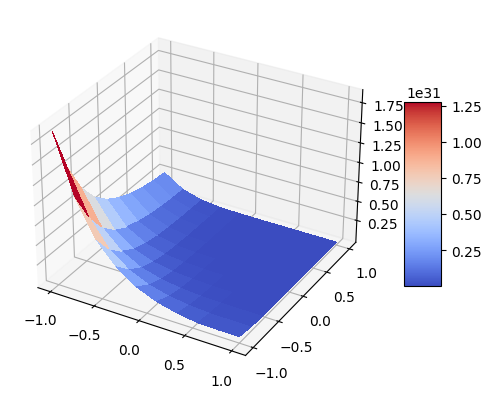

In [ ]:

# 3d plot
landscapeviz.plot_3d(key="categorical_crossentropy", log=False)

In [ ]:
print("Test Loss:", test_loss)
